In [329]:
import pandas as pd
import numpy as np

In [330]:
random_seed = 33
np.random.seed(random_seed)

In [331]:
users = pd.read_csv('data/users.csv', encoding='iso-8859-1')
engagement = pd.read_csv('data/user_engagement.csv', encoding='iso-8859-1')

In [332]:
users.shape, engagement.shape

((12000, 10), (207917, 3))

In [333]:
users.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0


In [334]:
users.info(), engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count  

(None, None)

In [335]:
# Convert to timestams
users['creation_time'] = pd.to_datetime(users['creation_time'], format='%Y-%m-%d %H:%M:%S')
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'], format='%Y-%m-%d %H:%M:%S')

In [336]:
# Rename and re-type columns
users = users.rename(columns={'object_id': 'user_id'})
users['opted_in_to_mailing_list'] = users['opted_in_to_mailing_list'].astype(bool)
users['enabled_for_marketing_drip'] = users['enabled_for_marketing_drip'].astype(bool)
users['org_id'] = users['org_id'].astype('category')

In [337]:
users.info(), engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  bool          
 7   enabled_for_marketing_drip  12000 non-null  bool          
 8   org_id                      12000 non-null  category      
 9   invited_by_user_id          6417 non-null   float64       
dtypes: bool(2), category(1), datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 722.7+ KB
<class 'pandas.cor

(None, None)

In [338]:
engagement.head(20)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1
6,2014-01-08 03:45:04,2,1
7,2014-02-03 03:45:04,2,1
8,2014-02-08 03:45:04,2,1
9,2014-02-09 03:45:04,2,1


> Based on this engagement data, User id =2 should be tagged as a user who adopted. \
> Assert later that adopoion for user_id == 2 should be True

In [339]:
#Group by user id
eng_gby_user = engagement.groupby('user_id')

In [340]:
for k, v in list(eng_gby_user.groups.items())[:3]:
    print(f"User ID: {k}, Engagement Records: {v}")


User ID: 1, Engagement Records: Index([0], dtype='int64')
User ID: 2, Engagement Records: Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], dtype='int64')
User ID: 3, Engagement Records: Index([15], dtype='int64')


In [341]:
# Sort by timestamp with each user
eng_by_user  = eng_gby_user.apply(lambda x: x.sort_values('time_stamp').reset_index(drop=True))

/tmp/ipykernel_58772/4008739695.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eng_by_user  = eng_gby_user.apply(lambda x: x.sort_values('time_stamp').reset_index(drop=True))


In [342]:
# Use udf to check user adoption based on the given criteria
def is_adopted(data_df):

    # if there are less than 3 records, the user is not adopted    
    if len(data_df) < 3:
        return False

    # Sort + loop at time stamps. Check if there are at least 3 records within 7 day period
    data_df = data_df.sort_values('time_stamp')
    
    for i in range(len(data_df) - 2):

        # Check date diff is lte to 7 days
        if data_df['time_stamp'].iloc[i + 2] - data_df['time_stamp'].iloc[i] <= pd.Timedelta(days=7):
            return True

    return False

In [343]:
# def user_adopted(data_df):
#     data_df = data_df.sort_values('time_stamp')
#     for i in range(len(data_df) - 2):
#         if (data_df['time_stamp'].iloc[i+2] - data_df['time_stamp'].iloc[i]).days <= 7:
#             return 1
#     return 0

In [344]:
# df_adoption = engagement.groupby('user_id').apply(user_adopted).reset_index().rename(columns={0: 'adopted'})
# df_adoption.adopted.value_counts()

In [345]:
# Apply udf and check user adoption counts
eng_by_user_adopted  = eng_gby_user.apply(is_adopted).reset_index()
eng_by_user_adopted = eng_by_user_adopted.rename(columns={0: 'adopted'})
eng_by_user_adopted.adopted.value_counts()

/tmp/ipykernel_58772/90698122.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eng_by_user_adopted  = eng_gby_user.apply(is_adopted).reset_index()


adopted
False    7167
True     1656
Name: count, dtype: int64

In [346]:
# count_adopted_users = len(eng_by_user_adopted[eng_by_user_adopted.adopted == True])
# print(f"Number of adopted users: {count_adopted_users}")
# ratio_adopted_users = count_adopted_users / len(users)
# print(f"Ratio of adopted users: {ratio_adopted_users:.2%}")

In [347]:
# Pre-merge, verify_ids are unique 
users.user_id.value_counts().sort_values(ascending=False).head(5)

user_id
1     1
10    1
23    1
22    1
3     1
Name: count, dtype: int64

In [348]:
# Merge the label with the users
user_adoption = pd.merge(users, eng_by_user_adopted, on='user_id', how='left')
user_adoption['adopted'] = user_adoption['adopted'].fillna(False)

/tmp/ipykernel_58772/3867807166.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  user_adoption['adopted'] = user_adoption['adopted'].fillna(False)


In [349]:
# % Missing values in the user_adoption dataset
missing_values = user_adoption.isna().sum()
missing_values_percentage = (missing_values / len(user_adoption)) * 100
print("Percentage of missing values in each column:")
print(missing_values_percentage)

Percentage of missing values in each column:
user_id                        0.000
creation_time                  0.000
name                           0.000
email                          0.000
creation_source                0.000
last_session_creation_time    26.475
opted_in_to_mailing_list       0.000
enabled_for_marketing_drip     0.000
org_id                         0.000
invited_by_user_id            46.525
adopted                        0.000
dtype: float64


In [350]:
user_adoption.adopted.value_counts()

adopted
False    10344
True      1656
Name: count, dtype: int64

In [351]:
assert user_adoption[user_adoption.user_id == 2]['adopted'].values[0] == True

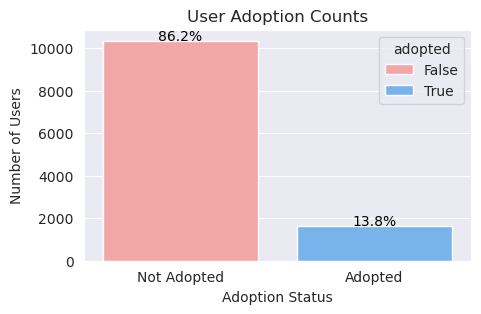

In [352]:
import seaborn as sns

# Plot the user adoption counts separate by adopted and not adopted users
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 3))
adopt_counts = user_adoption['adopted'].value_counts().reset_index()
adopt_counts.columns = ['adopted', 'count']
sns.barplot(data=adopt_counts, x='adopted', y='count', hue='adopted', palette=['#FF9999', '#66B3FF'])
# put percentage on top of bars
for index, row in adopt_counts.iterrows():
    # plt.text(row.name, row['count'] + 0.5, f"{row['count']}", color='black', ha='center')
    plt.text(row.name, row['count'] - 0.5, f"{row['count'] / adopt_counts['count'].sum() * 100:.1f}%", color='black', ha='center')
    
plt.xlabel('Adoption Status')
plt.ylabel('Number of Users')
plt.title('User Adoption Counts')
plt.xticks(ticks=[0, 1], labels=['Not Adopted', 'Adopted'])
plt.show()


> Theres an obvious imbalance in the dataset, with a much larger number of users not adopted compared to those who are adopted. This is a common scenario in user engagement datasets, where the majority of users may not engage with the product or service to the extent defined as "adopted".

In [353]:
from sklearn.utils import shuffle, resample
# Shuffle the user adoption data

majority_class = user_adoption[user_adoption['adopted'] == False]
minority_class = user_adoption[user_adoption['adopted'] == True]

# Upsample the minority class
minority_upsampled = resample(minority_class, 
                              replace=True,    
                              n_samples=len(majority_class),   
                              random_state=random_seed) 

# Combine majority class with upsampled minority class
df = pd.concat([majority_class, minority_upsampled])

In [354]:
print("Original class distribution:")
print(user_adoption['adopted'].value_counts())
print("\nAfter upsampling minority class:")
print(df['adopted'].value_counts())

Original class distribution:
adopted
False    10344
True      1656
Name: count, dtype: int64

After upsampling minority class:
adopted
False    10344
True     10344
Name: count, dtype: int64


In [355]:
latest_acct_date = df.creation_time.max()
oldest_acct_date = df.creation_time.min()
oldest_acct_date,latest_acct_date

(Timestamp('2012-05-31 00:43:27'), Timestamp('2014-05-30 23:59:19'))

In [356]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20688 entries, 0 to 10643
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     20688 non-null  int64         
 1   creation_time               20688 non-null  datetime64[ns]
 2   name                        20688 non-null  object        
 3   email                       20688 non-null  object        
 4   creation_source             20688 non-null  object        
 5   last_session_creation_time  17511 non-null  float64       
 6   opted_in_to_mailing_list    20688 non-null  bool          
 7   enabled_for_marketing_drip  20688 non-null  bool          
 8   org_id                      20688 non-null  category      
 9   invited_by_user_id          11313 non-null  float64       
 10  adopted                     20688 non-null  bool          
dtypes: bool(3), category(1), datetime64[ns](1), float64(2), int

In [357]:
# Feature Engineer columns
df['last_session_creation_time'] = pd.to_datetime(df['last_session_creation_time'], unit='s', errors='coerce')

df['acct_age'] = (latest_acct_date - df.creation_time).dt.days
df['login_age'] = (latest_acct_date - df['last_session_creation_time']).dt.days
df['invitee'] = df['invited_by_user_id'].notnull().astype('bool')


In [358]:
print(f'Unique org id: {df.org_id.nunique()}')
print(f'Unique user id: {df.user_id.nunique()}')
print(f'Unique creation source: {df.creation_source.nunique()}')

Unique org id: 417
Unique user id: 11998
Unique creation source: 5


In [359]:
df.creation_source.value_counts()

creation_source
ORG_INVITE            7260
GUEST_INVITE          4053
SIGNUP                3662
PERSONAL_PROJECTS     3040
SIGNUP_GOOGLE_AUTH    2673
Name: count, dtype: int64

In [360]:
df = pd.get_dummies(df, columns=['creation_source'], prefix='src_')
df.head()

,user_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,acct_age,login_age,invitee,src__GUEST_INVITE,src__ORG_INVITE,src__PERSONAL_PROJECTS,src__SIGNUP,src__SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,2014-04-22 03:53:30,True,False,11,10803.0,False,38,38.0,True,True,False,False,False,False
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,2013-03-19 23:14:52,False,False,94,1525.0,False,437,437.0,True,False,True,False,False,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,2013-05-22 08:09:28,False,False,1,5151.0,False,374,373.0,True,True,False,False,False,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,2013-01-22 10:14:20,False,False,193,5240.0,False,498,493.0,True,True,False,False,False,False
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,2013-12-19 03:37:06,False,False,197,11241.0,False,164,162.0,True,True,False,False,False,False


> Interpretability: As the goal is to interpret the influence of each category on the classification outcome, dropping one category can make interpretation slightly more complex. \
> Note on Tree-based Models: For tree-based models such as Random Forests or XGBoost, setting drop_first=False is typically fine. These models don't assume feature relationships in the same way linear models do, making them less susceptible to the effects of multicollinearity from one-hot encoded variables.

In [361]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20688 entries, 0 to 10643
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     20688 non-null  int64         
 1   creation_time               20688 non-null  datetime64[ns]
 2   name                        20688 non-null  object        
 3   email                       20688 non-null  object        
 4   last_session_creation_time  17511 non-null  datetime64[ns]
 5   opted_in_to_mailing_list    20688 non-null  bool          
 6   enabled_for_marketing_drip  20688 non-null  bool          
 7   org_id                      20688 non-null  category      
 8   invited_by_user_id          11313 non-null  float64       
 9   adopted                     20688 non-null  bool          
 10  acct_age                    20688 non-null  int64         
 11  login_age                   17511 non-null  float64       


In [365]:
# select features
feats = ['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'login_age', 'acct_age', 'invitee']
feats += [col for col in df.columns if col.startswith('src_')]

In [366]:
X = df[feats]
y = df['adopted']

In [ ]:
# Train-Test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=random_seed, test_size=0.2)

In [ ]:
# Use hyperopt to optimize a Random Forest Classifier

from hyperopt import fmin, tpe, hp, Trials, space_eval
from sklearn.ensemble import RandomForestClassifier 


Use class_weight in models (e.g., for sklearn classifiers)

Use evaluation metrics suitable for imbalance (precision, recall, f1, ROC-AUC)